In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

import quantstats as qs

In [2]:
def get_exp_path(expid):
    expid = str(expid)
    logs_folder = Path(r"C:\Users\Mathiass\Documents\Projects\master-thesis")/"logs"
    matches = Path(logs_folder).rglob(expid) #Get folder in logs_folder that matches expid
    matches_list = list(matches)
    if not len(matches_list) == 1:
        raise ValueError(f"There exists none or more than 1 folder with "
                            f"experiment id {expid} in the {logs_folder.name} "
                            "directory!")
    exp_dir = matches_list[0]
    return exp_dir

In [3]:
# def omega_ratio(returns, return_threshold=0.0):
    
#     ret_above = returns[returns > return_threshold]
#     ret_below = returns[returns < return_threshold]
    
#     return sum(ret_above)/ (-1*sum(ret_below))

In [4]:
def omega_ratio(returns, return_threshold=0.0):
    return_less_thresh = returns - return_threshold
    
    numer = sum(return_less_thresh[return_less_thresh > 0.0])
    denom = -1.0 * sum(return_less_thresh[return_less_thresh < 0.0])
    
    if denom > 0.0:
        return numer/denom
    else:
        return np.nan

In [5]:
p = get_exp_path(20220924104656)

In [6]:
p

WindowsPath('C:/Users/Mathiass/Documents/Projects/master-thesis/logs/production/medium/xgb/20220924104656')

In [7]:
long3short1 = pd.read_csv(p/"portfolios/long3short1.csv", index_col="date", parse_dates=["date"])
long4short0 = pd.read_csv(p/"portfolios/long4short0.csv", index_col="date", parse_dates=["date"])

In [8]:
opt_ret = long3short1["option_ret"]

In [9]:
opt_ret

date
2008-01-31    0.009818
2008-02-29    0.010466
2008-03-31   -0.001804
2008-04-30    0.027676
2008-05-31   -0.012067
                ...   
2021-06-30    0.007169
2021-07-31    0.005231
2021-08-31    0.001633
2021-09-30    0.000568
2021-10-31    0.010533
Name: option_ret, Length: 166, dtype: float64

In [10]:
opt_ret.mean()

0.00450407361627532

Skewness: 0.08949895325040484
Kurtosis: 1.6828617202320575


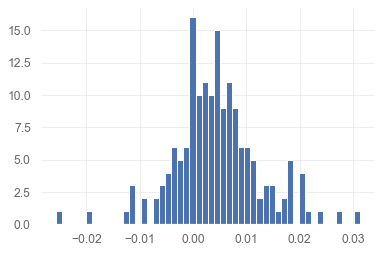

In [11]:
opt_ret.hist(bins=50)
print("Skewness:", opt_ret.skew())
print("Kurtosis:", opt_ret.kurt())

In [12]:
omega_ratio(opt_ret)

4.738448447982919

In [13]:
omega_ratio(opt_ret, 0.0001)

4.579620886342597

In [14]:
# def col_wise(func):
#     def wrapper(df, *args, **kwargs):
#         return df.apply(func, *args, **kwargs, axis=0)
#     return wrapper

# f = col_wise(qs.stats.sharpe)

# f(a, periods=12)

In [15]:
opt_ret = pd.concat([long3short1["option_ret"], long4short0["option_ret"]], axis=1)

In [16]:
opt_ret.apply(omega_ratio)

option_ret    4.738448
option_ret    7.424543
dtype: float64

In [17]:
opt_ret.apply(qs.stats.sharpe, periods=12, axis=0)

option_ret    1.916014
option_ret    1.698338
dtype: float64

In [18]:
opt_ret.apply(qs.stats.adjusted_sortino, periods=12)

option_ret    3.051000
option_ret    4.383169
dtype: float64

In [19]:
a = opt_ret.iloc[:, 0]

### (Adjusted) Sortino

In [20]:
# Adjusted sortino
from math import sqrt
a.mean() / sqrt(sum((a[a < 0.0])**2) /len(a)) / sqrt(2) * sqrt(12)

3.0510002880070233

### Calmar Ratio

In [21]:
# Max Drawdown.
from pandas.tseries.offsets import MonthEnd
try:
    a = a.to_frame()
except:
    pass
pf_returns_dd = a.copy()
# Insert [0, 0, ..., 0] as first prices, to calculate MaxDD correctly.
pf_returns_dd.loc[pf_returns_dd.index[0] - MonthEnd(1)] = [0] * pf_returns_dd.shape[1]
pf_returns_dd = pf_returns_dd.sort_index()
prices = (1 + pf_returns_dd).cumprod()
maxdd = (prices / prices.expanding().max()).min() - 1 #formula from quantstats
# maxdd_str = maxdd.apply(to_pct_string).rename("Max Drawdown")

In [22]:
maxdd

option_ret   -0.034359
dtype: float64

In [37]:
((1+a).prod() ** (12/len(a)) - 1)

option_ret    0.054995
dtype: float64

In [40]:
# Calmar Ratio
((1+a).prod() ** (12/len(a)) - 1) / abs(maxdd)

option_ret    1.600604
dtype: float64

In [23]:
# def semi_variance(returns):
#     mean = returns.mean()
    
#     ret_below_mean = returns[returns < mean]
    
#     return ret_below_mean.